### Example to mimic old PTW

This is a notebook with parameter values set to mimic the old PTW calibration

In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\Chiyoung Ahn\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [2]:
import Pkg
using PerlaTonettiWaugh, Plots, BenchmarkTools

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1190


Below is the calibration, the gbm and death rate set to be small values. The otheres are viturally taken from Tabe 1. The only ones that are a bit fuzzy are $\kappa$ which was rounded up and then the $\chi$ which is a bit higher. I beleve that this may have been a typo in the paper.

In [3]:
cal_old_paper = (d = 4.0 , θ = 3.1878, κ = 0.006 , χ = 1.00/2.80, υ = 0.001, σ =3.0, ζ = 1.00, δ = 0.001)
cal = cal_old_paper

(d = 4.0, θ = 3.1878, κ = 0.006, χ = 0.35714285714285715, υ = 0.001, σ = 3.0, ζ = 1.0, δ = 0.001)

In [4]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_x0 = [-0.9802869871313153, -0.7679611162133799, -0.6483822140201239, -0.5709998420691726, -0.4410497194161549, -0.35188633823047205, -0.28134090933192113, -0.22721306548238096, -0.2132657066634307, -0.1802989139615504, -0.1407983331567128, -0.10561616300315106, -0.08546763464126883, -0.058948603687082865, -0.02960294672034148, -0.020649289609280547, -0.013922070758445242, -0.008451708149201357, -0.0039236251615955165],
        z = unique([range(0., 0.1, length = 400)' range(0.1, 1., length = 400)' range(1., 2*(settings.z_max), length = 200)']),
        T = 120.0))
z_grid = settings.z
M = length(z_grid)

d_0 = 10.0 # This will get us near autarky.
d_T = cal.d

params_0 = merge(parameters, (d = d_0, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ , δ  = cal.δ, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ , δ  = cal.δ, )) # parameters to be used at t = T

# initial value
initial_x = [0.02; 2; .57] # Play with this if it is kicking back errors

# solve for stationary solution at t = 0
stationary_sol_atuk = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T

Ω_0 = stationary_sol_atuk.Ω;
Ω_T = stationary_sol.Ω;

In [5]:
display_stationary_sol(stationary_sol);

g = 0.01983439936084155
z_hat = 1.5936783198181008
Ω = 2.8840193266295664
y = 2.4782483939709876
c = 2.4782483939709876
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.01983439936084155, 0.02, 1.0, 2.4782483939709876)
λ_ii = 0.7556417685825898
L_tilde = 0.22566327836874644
z_bar = 3.2004789708929144
w = 1.0668263236309714
x = 1.0
π_min = 0.037798094270956144
r = 0.04083439936084155
a = 16.483480603412605
b = 0.16999915747285319
S = 0.0632230172480707


In [6]:
display_stationary_sol(stationary_sol_atuk);

g = 0.013725354634016411
z_hat = 3.9842405006231116
Ω = 3.942882299266904
y = 2.6704568623434874
c = 2.6704568623434874
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.013725354634016411, 0.02, 1.0, 2.6704568623434874)
λ_ii = 0.9828742334343232
L_tilde = 0.18613239410574606
z_bar = 3.281193210054438
w = 1.093731070018146
x = 1.0
π_min = 0.03779724612633416
r = 0.03472535463401641
a = 20.64038475138108
b = 0.7454480347330976
S = 0.04374860446789752


#### Comparison of Steady States

First notice that the growth rate is near similar in autarky to that in Table 2. Then the second part computes the consumption equivalent 

In [7]:
print(stationary_sol_atuk.g,"\n")

print(100*(stationary_sol.U_bar(0)/stationary_sol_atuk.U_bar(0)-1),"\n")

lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar(0), stationary_sol_atuk.U_bar(0), parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

0.013725354634016411
13.82992475406466
SS to SS welfare gain: 25.955021744897433


So all this stuff is roughly matching up with what we had in Table 2. About a 1.38 growth rate, 13 percent increase in utility, 26 (24 in paper) in consumption units.

#### Transition Path

In [8]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, z_grid), Ω_0 = Ω_0, transition_iterations = 1000));

In [9]:
@time result = solve_full_model(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;
solved = solved.results;

┌ Warning: `binary_maxheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMaxHeap(xs)` instead.
│   caller = #FunctionCallingCallback#24(::Array{Float64,1}, ::Bool, ::Bool, ::Int64, ::Function, ::Function) at function_caller.jl:75
└ @ DiffEqCallbacks C:\Users\Chiyoung Ahn\.julia\packages\DiffEqCallbacks\WQXZl\src\function_caller.jl:75
┌ Warning: `binary_maxheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMaxHeap(xs)` instead.
│   caller = tstop_saveat_disc_handling at solve.jl:514 [inlined]
└ @ Core C:\Users\Chiyoung Ahn\.julia\packages\Sundials\AL2Km\src\common_interface\solve.jl:514
┌ Warning: `binary_maxheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMaxHeap(xs)` instead.
│   caller = #__init#58(::Bool, ::Nothing, ::Float64, ::Bool, ::Bool, ::DiffEqBase.DiscreteCallback{getfield(DiffEqCallbacks, Symbol("##25#26")),DiffEqCallbacks.FunctionCallingAffect{getfield(PerlaTonettiWaugh, Symbol("#cb_aux#81")){getfield(PerlaTonettiWaugh, Symbol("#Ω#125"

177.294176 seconds (304.41 M allocations: 247.924 GiB, 15.97% gc time)


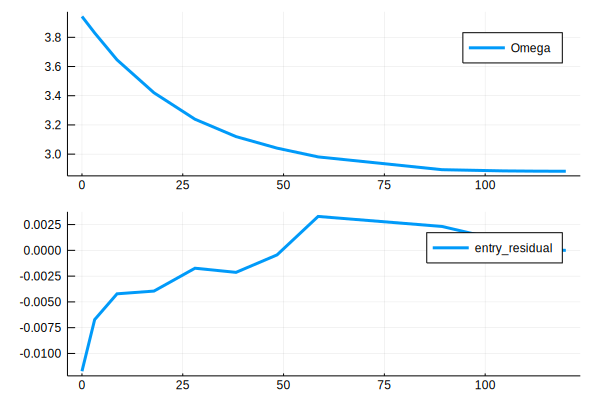

In [10]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

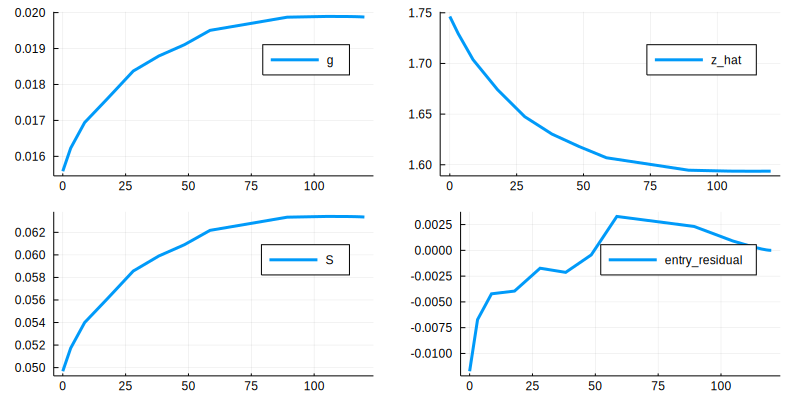

In [11]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

#### Welfare Including Transition Path

Here it is

In [12]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_atuk.U_bar(0), parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 59.43418968460033


So the transition makes welfare INCREASE by a factor of 4....

### Saving results in .csv files

In [13]:
using CSV
CSV.write("old_pwt_tpath-results.csv", solved)

"old_pwt_tpath-results.csv"